# Assignment 6

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response work, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.

This jupyter notebook should look somewhat like a report. It should be easy to follow for someone who understands how to write the code and interpret your results!





### Problem 1: Stocks (revisited with `stan`)

Previously we took unconstrained multivariate data, and we used a multivariate normal distribution for it. That is, suppose each length $k$ row is called $y_i$ and that each row is independent. Then

$$
L(y_1, \ldots, y_N \mid \theta) = \prod_{j=1}^N L(y_j \mid \theta)
$$

where $\theta = (\mu, \Sigma)$ and 

$$
 y_k \mid \mu, \Sigma \sim \text{Normal}(\mu, \Sigma).
$$

We used the **Normal Inverse Wishart** prior because it's the conjugate prior. That involves choosing $\mu_0, \kappa_0, \Lambda_0, \nu_0$ Now I'll introduce a different prior that is very popular for `stan` users that is simpler to choose and sometimes produces a posterior that is easier to sample from.



In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

1.

Download the data `stocks.csv` and assign it to a `pandas` `DataFrame` called `adj_prices`. Be sure to set the date as the index.

Calculate percent returns (scaled by $100$) and call the resulting `DataFrame` `rets`. After understanding where they come from, be sure to remove any `NaN`s.

In [32]:
rets = pd.read_csv("stocks.csv")[['SPY','QQQ']].pct_change().dropna()
rets.head()

,SPY,QQQ
1,-0.007572,-0.009160
2,0.003815,0.006443
3,-0.002812,-0.000139
4,0.005330,0.007516
5,0.006781,0.008474


2.

Use the same prior as you did for homework 4 and simulate from the prior predictive distribution. Instead of doing it with your own handwritten function `sim_data()`, use `stan` to accomplish this. Produce appropriate visualizations and comment on them. 

NB: If I might suggest a small tweak to the demo code--don't hardcode any prior hyperparams. This will make it easier to change your prior later on!

In [40]:
K=2
nu0 = 5
Lambda0 = np.identity(2)
mu0 = np.zeros(2)
kappa0 = 1

stan_data = {
    "K":rets.shape[1],
    "N":rets.shape[0],
    "y":rets.values,
    "nu":nu0,
    "Lambda":Lambda0,
    "mu_0":mu0,
    "kappa_0":kappa0
}

posterior = CmdStanModel(stan_file="./NIW.stan")

15:50:59 - cmdstanpy - INFO - compiling stan file /bml24/assignment6/NIW.stan to exe file /bml24/assignment6/NIW
15:51:38 - cmdstanpy - INFO - compiled model executable: /bml24/assignment6/NIW


In [41]:
fit = posterior.sample(stan_data)

15:51:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:52:05 - cmdstanpy - INFO - CmdStan done processing.
15:52:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'NIW.stan', line 18, column 2 to column 34)
Exception: inv_wish

In [42]:
#Summary diagnostics all close to 1!
fit.summary()['R_hat']

lp__          1.000560
mu[1]         0.999591
mu[2]         0.999543
Sigma[1,1]    1.002400
Sigma[1,2]    1.000180
Sigma[2,1]    1.000180
Sigma[2,2]    1.001600
Name: R_hat, dtype: float64

<Axes: >

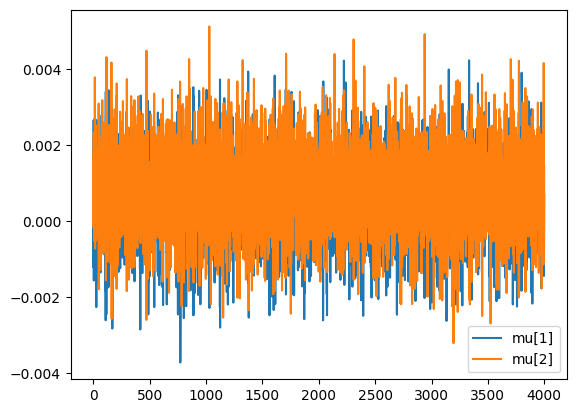

In [43]:
#Fuzzy caterpillar looks good!
fit.draws_pd()[['mu[1]', 'mu[2]']].plot()

<Axes: >

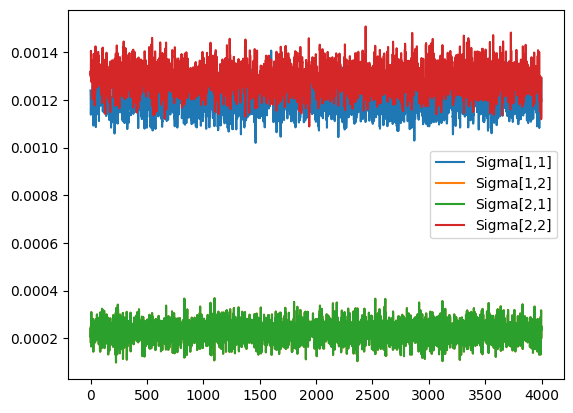

In [44]:
# All sigmas fuzzy caterpillars!
fit.draws_pd()[['Sigma[1,1]', 'Sigma[1,2]', 'Sigma[2,1]', 'Sigma[2,2]']].plot()

3.

Simulate parameters from the posterior using `stan`. Describe how to treat diagnostics, and then interpret and display your results. Take note of any interesting findings regarding parameter estimates. 

Try to use [`hist2d()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html) to visualize the posteriof of $\mu$.
For visualizing the covariance matrix samples, just plot the three unique values on overlaid histograms.
                                                   

In [46]:
print(fit.diagnose())

Processing csv files: /tmp/tmpcqurst2a/NIWhrtijc89/NIW-20240628155138_1.csv, /tmp/tmpcqurst2a/NIWhrtijc89/NIW-20240628155138_2.csv, /tmp/tmpcqurst2a/NIWhrtijc89/NIW-20240628155138_3.csv, /tmp/tmpcqurst2a/NIWhrtijc89/NIW-20240628155138_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



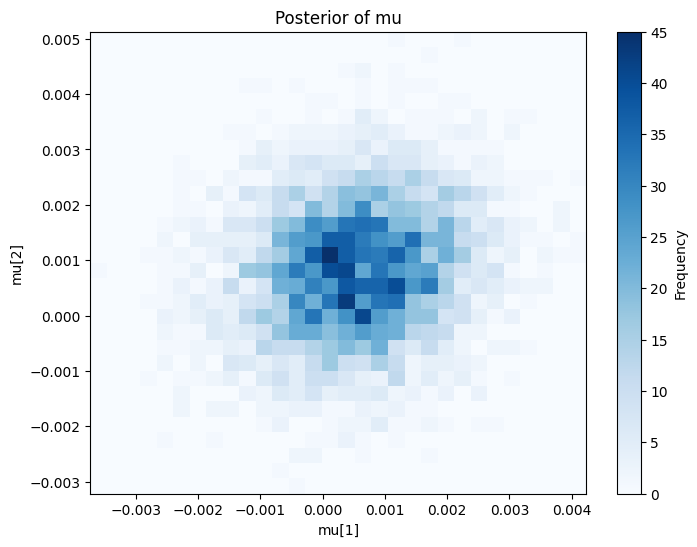

In [100]:
fit_data = fit.draws_pd()

mu_samples = fit_data[['mu[1]', 'mu[2]']].reset_index(drop=True)

mu_1_samples = mu_samples['mu[1]'].values
mu_2_samples = mu_samples['mu[2]'].values


#Comments:

#Majority of values around .001 for mu[2] and between .000 and .001 for mu[1]

plt.figure(figsize=(8, 6))
plt.hist2d(mu_1_samples, mu_2_samples, bins=30, cmap='Blues')
plt.xlabel('mu[1]')
plt.ylabel('mu[2]')
plt.title('Posterior of mu')
plt.colorbar(label='Frequency')
plt.show()

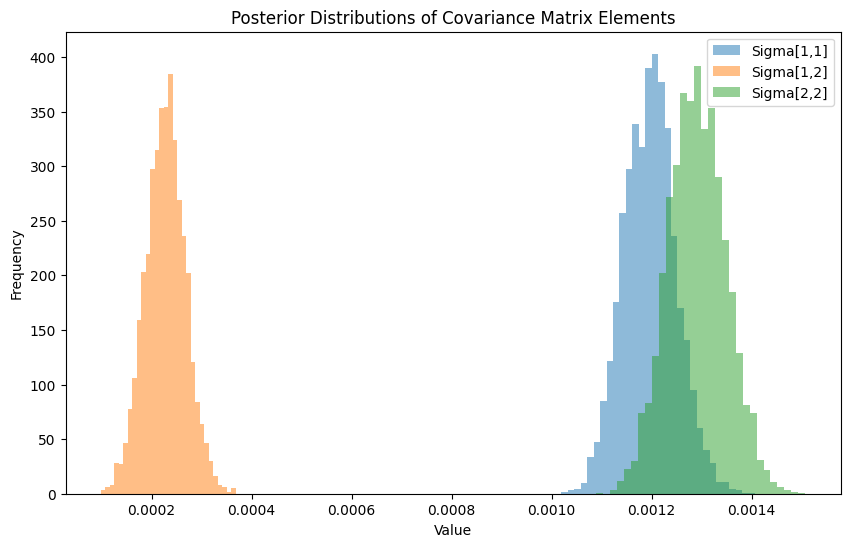

In [65]:
sigma_samples = fit_data[['Sigma[1,1]', 'Sigma[2,1]', 'Sigma[1,2]', 'Sigma[2,2]']]

sigma_11_samples = sigma_samples['Sigma[1,1]']
sigma_22_samples = sigma_samples['Sigma[2,2]']
sigma_12_samples = sigma_samples['Sigma[1,2]']

#Comments: 

# All decent normally distributed sigmas centered around different points, Sigma[2,1] unnecessary as it will directly overlap with Sigma[1,2] by the definition of covariance, order is irrelevant.

plt.figure(figsize=(10, 6))
plt.hist(sigma_11_samples, bins=30, alpha=0.5, label='Sigma[1,1]')
plt.hist(sigma_12_samples, bins=30, alpha=0.5, label='Sigma[1,2]')
plt.hist(sigma_22_samples, bins=30, alpha=0.5, label='Sigma[2,2]')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Posterior Distributions of Covariance Matrix Elements')
plt.legend()
plt.show()

4.

Take your chosen portfolio weights from homework 4 and simulate portfolio returns from the posterior predictive distribution. Are they "good?" Visualize them in a variety of interesting ways!

How do these returns compare with "backtested" returns? In other words, how do these simulated returns compare with taking the same weight vector, and seeing how they did retrospectively on "real" (not simulated) data. 

Keep in mind that retrospective analysis is not always indicative of future results!

In [69]:
#Setting up posterior hyperparamaters for NIW 

n = rets.shape[0]

y_bar = np.mean(rets, axis=0)
S = (rets.T @ rets).values

nu_n = nu0 + n
kappa_n = kappa0 + n
mu_n = (kappa0 * mu0 + n * y_bar) / (kappa0 + n)
Lambda_n = Lambda0 + S + (kappa0 * n / (kappa0 + n)) * np.outer(y_bar - mu0, y_bar - mu0)

In [133]:
import scipy.stats as stats

n_sim = 1000 

# Initialize an array to store simulated returns
simulated_portfolio_returns = []

mu_samples_val = mu_samples.values.reshape(-1,2)
sigma_samples_val = sigma_samples.values.reshape(-1,2,2)

n_params = mu_samples_val.shape[0]


for _ in range(n_params):
    # Sample Sigma from the inverse Wishart distribution
    sigma = stats.invwishart.rvs(df=nu_n, scale=Lambda_n)
    
    # Sample mu from the multivariate normal distribution
    mu = np.random.multivariate_normal(mu_n, sigma / kappa_n)

    # Simulate returns
    y_sim = np.random.multivariate_normal(mu, sigma, n_sim)
    
    # Calculate portfolio returns for each simulation
    weights = np.array([0.5, 0.5])  # Example weights
    portfolio_returns = y_sim @ weights
    simulated_portfolio_returns.extend(portfolio_returns)

simulated_portfolio_returns = np.array(simulated_portfolio_returns)

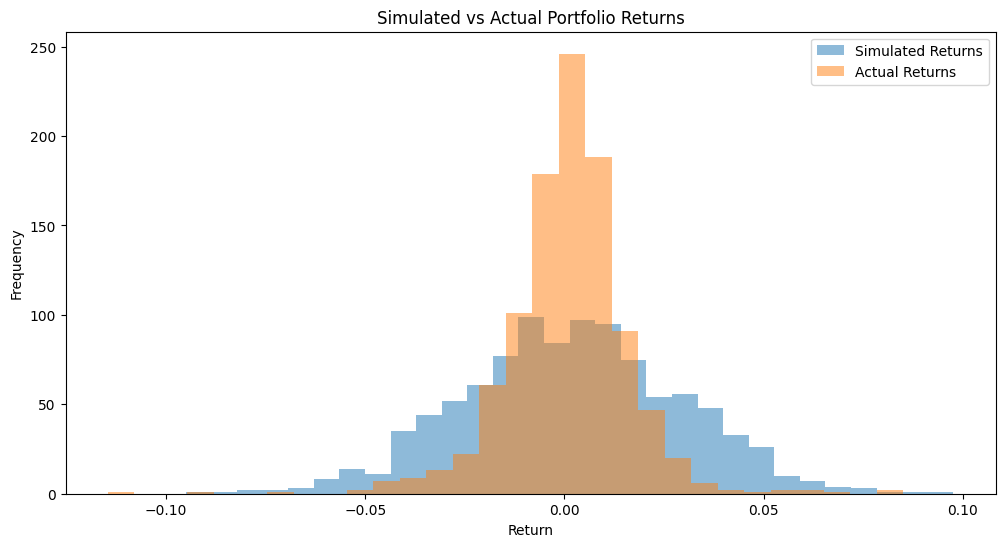

In [136]:
# Calculate actual portfolio returns
weights = np.array([0.5, 0.5])  # Example weights
actual_portfolio_returns = rets @ weights

# Visualize the simulated returns
plt.figure(figsize=(12, 6))
plt.hist(simulated_portfolio_returns[:1005], bins=30, alpha=0.5, label='Simulated Returns')
plt.hist(actual_portfolio_returns, bins=30, alpha=0.5, label='Actual Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Simulated vs Actual Portfolio Returns')
plt.legend()
plt.show()

#Comments:

#Decent fit but with more samples we get closer to the actual, our model seems to predict losses or gains more often than nothing where nothing or 0.0 is more common in actual data

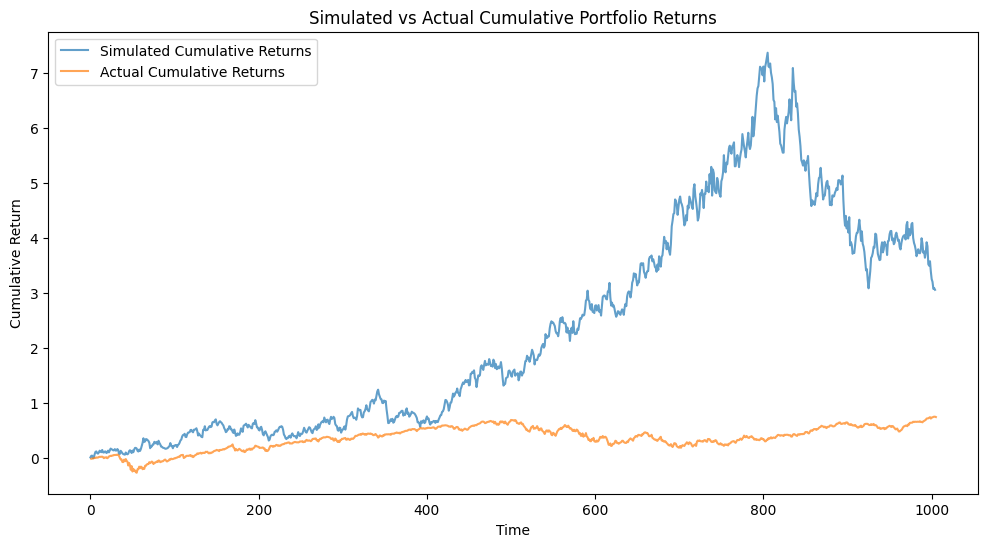

In [138]:
simulated_cumulative_returns = np.cumprod(1 + simulated_portfolio_returns) - 1
actual_cumulative_returns = np.cumprod(1 + actual_portfolio_returns) - 1

plt.figure(figsize=(12, 6))
plt.plot(simulated_cumulative_returns[:1005], label='Simulated Cumulative Returns', alpha=0.7)
plt.plot(actual_cumulative_returns, label='Actual Cumulative Returns', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Simulated vs Actual Cumulative Portfolio Returns')
plt.legend()
plt.show()

#Comments: 

# Once again our model appears to predict more returns than are actually existant in the data, this tracks with the previous visual showing losses or gains as being much more commmon

5.

Simulate parameters from the posterior after making adjustments to your prior. Do not feel obligated to re-do all of the same work you did in the previous problem. Instead, discuss (qualitatively) how sensitive your posterior appears to be to the choices you made on your prior. 

In [141]:
# Adjusted Prio Hyperparams
stan_data_adj = {
    "K":rets.shape[1],
    "N":rets.shape[0],
    "y":rets.values,
    "nu":nu0 + 10,
    "Lambda":Lambda0 * 2,
    "mu_0":mu0,
    "kappa_0":0.5
}

fit_adjusted = posterior.sample(stan_data_adj)

16:40:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:40:56 - cmdstanpy - INFO - CmdStan done processing.
16:40:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is -nan. (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is -nan. (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'NIW.stan', line 18, column 2 to column 34)
Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'NIW.stan', line 18, column 2 to column 34)
	Exception: inv_wishart_lpdf:

In [142]:
#reducing confidence by increasing degrees of freedom, increasing the scale matrix lambda and reducing the scaling factor kappa has resulted in much more seemingly accurate parameters 
#with mu hovering around 0 more confidently, which is definitely more indicative of the actual data we see. Adjusting these parameters as I have essentially reduced the models 
#confidence and has it more based on the data.

fit_adjusted.draws_pd().head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu[1],mu[2],"Sigma[1,1]","Sigma[2,1]","Sigma[1,2]","Sigma[2,2]"
0,1.0,1.0,1.0,5230.33,0.841836,0.396131,3.0,7.0,0.0,-5229.14,0.002486,-0.001067,0.002283,0.000311,0.000311,0.002143
1,1.0,2.0,2.0,5230.45,0.991250,0.396131,3.0,7.0,0.0,-5229.60,0.003097,-0.000351,0.002037,0.000288,0.000288,0.002344
2,1.0,3.0,3.0,5232.47,0.943463,0.396131,2.0,3.0,0.0,-5228.65,-0.000235,-0.000620,0.002053,0.000215,0.000215,0.002372
3,1.0,4.0,4.0,5232.63,0.986650,0.396131,4.0,15.0,0.0,-5231.75,0.000435,-0.000836,0.002266,0.000259,0.000259,0.002155
4,1.0,5.0,5.0,5232.34,0.972464,0.396131,3.0,15.0,0.0,-5231.56,0.000236,-0.001096,0.002033,0.000255,0.000255,0.002307


6.

Now choose any prior you want for the unknown mean and covariance matrix parameters. You can do anything you want as long as you

 - produce `stan` code that runs without error, and
 - use the LKJ distribution for the correlation matrix. 

Be sure to complete all the above steps:

 - simulate from the prior predictive distribution as a check on the prior;
 - simulate parameters from the posterior (check diagnostics, visualize and report); and
 - simulate from the posterior predictive distribution in the same way you did earlier.

In [157]:
# Define your data
K = rets.shape[1]
N = rets.shape[0]
mu_prior_mean = np.zeros(K)
mu_prior_sd = 1.0  # Scalar for simplicity

stan_data = {
    "K": K,
    "N": N,
    "mu_prior_mean": mu_prior_mean,
    "mu_prior_sd": mu_prior_sd,
    "y": rets.values
}

posterior_lkj = CmdStanModel(stan_file="./LKJ.stan")

In [158]:
#Simulate from prior predictive: 
fit_prior = posterior_lkj.sample(data=stan_data, fixed_param=True, iter_sampling=1000, chains=1)
y_sim_prior = fit_prior.draws_pd().filter(like="y_sim").values.reshape(-1, K)

17:01:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:01:35 - cmdstanpy - INFO - CmdStan done processing.


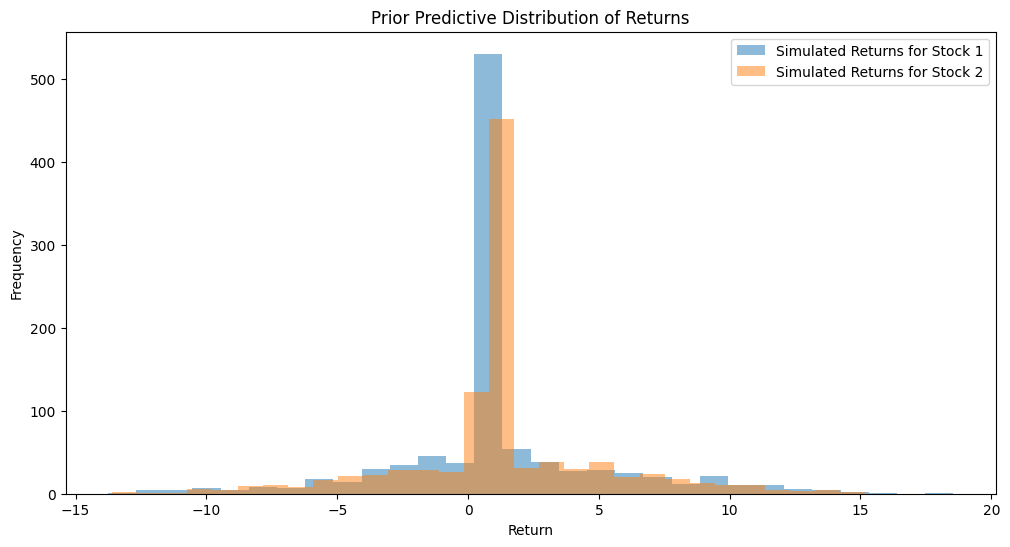

In [164]:
#Prior successfully sampled:

#Comments: 

#Values hovering around 0, this is good!

# Visualize the prior predictive distribution
plt.figure(figsize=(12, 6))
plt.hist(y_sim_prior[:1005, 0], bins=30, alpha=0.5, label='Simulated Returns for Stock 1')
plt.hist(y_sim_prior[:1005, 1], bins=30, alpha=0.5, label='Simulated Returns for Stock 2')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Prior Predictive Distribution of Returns')
plt.legend()
plt.show()

In [165]:
#Simulate parameters from Posterior:

fit_posterior = posterior_lkj.sample(data=stan_data, iter_sampling=2000, chains=4)

17:03:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:06:55 - cmdstanpy - INFO - CmdStan done processing.
17:06:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.stan', line 23, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'LKJ.sta

In [168]:
print(fit_posterior.diagnose())

Processing csv files: /tmp/tmpcqurst2a/LKJipam821h/LKJ-20240628170358_1.csv, /tmp/tmpcqurst2a/LKJipam821h/LKJ-20240628170358_2.csv, /tmp/tmpcqurst2a/LKJipam821h/LKJ-20240628170358_3.csv, /tmp/tmpcqurst2a/LKJipam821h/LKJ-20240628170358_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



<Axes: >

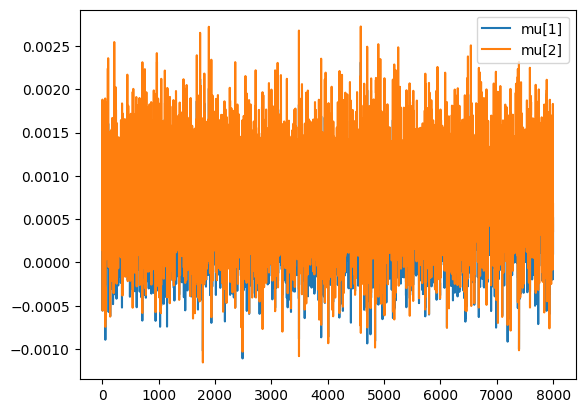

In [169]:
#Fuzzy caterpillar looks good!
fit_posterior.draws_pd()[['mu[1]', 'mu[2]']].plot()

In [171]:
fit_posterior.summary()['R_hat']

lp__             1.001480
mu[1]            0.999924
mu[2]            0.999907
L_Omega[1,1]          NaN
L_Omega[1,2]          NaN
                   ...   
y_sim[1003,2]    1.000270
y_sim[1004,1]    1.000020
y_sim[1004,2]    1.000160
y_sim[1005,1]    1.000320
y_sim[1005,2]    1.000140
Name: R_hat, Length: 2023, dtype: float64

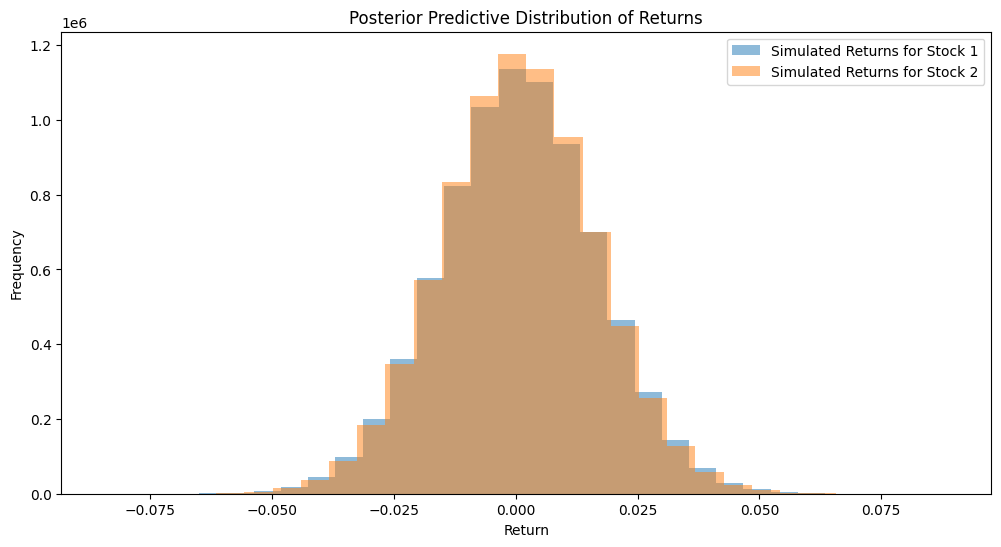

In [176]:
y_sim_posterior = fit_posterior.draws_pd().filter(like="y_sim").values.reshape(-1, K)

# Visualize the posterior predictive distribution, highest frequency at 0!
plt.figure(figsize=(12, 6))
plt.hist(y_sim_posterior[:, 0], bins=30, alpha=0.5, label='Simulated Returns for Stock 1')
plt.hist(y_sim_posterior[:, 1], bins=30, alpha=0.5, label='Simulated Returns for Stock 2')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution of Returns')
plt.legend()
plt.show()

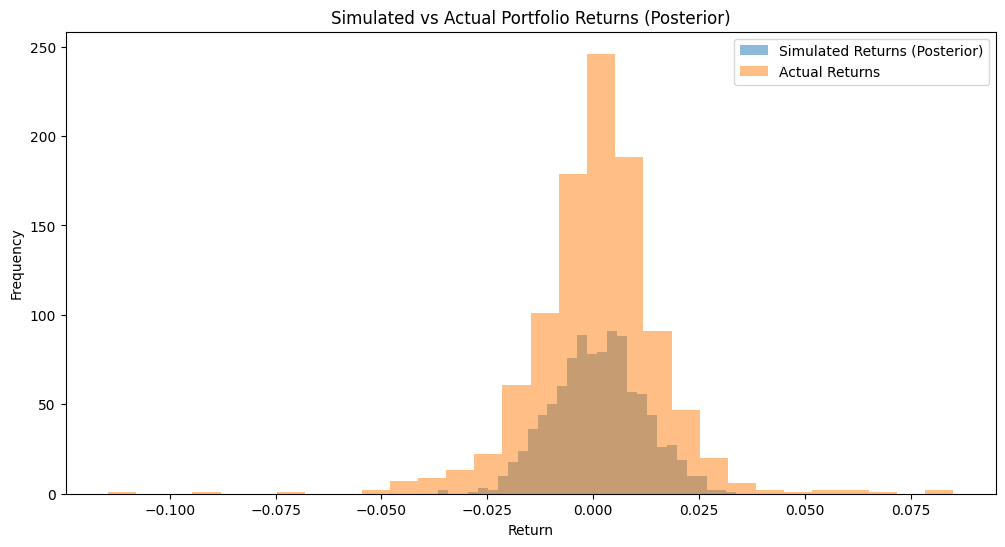

In [183]:
# Calculate and visualize portfolio returns
weights = np.array([0.5, 0.5])  # Example weights
simulated_portfolio_returns_posterior = y_sim_posterior @ weights
actual_portfolio_returns = rets @ weights

plt.figure(figsize=(12, 6))
plt.hist(simulated_portfolio_returns_posterior[:1005], bins=30, alpha=0.5, label='Simulated Returns (Posterior)')
plt.hist(actual_portfolio_returns, bins=30, alpha=0.5, label='Actual Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Simulated vs Actual Portfolio Returns (Posterior)')
plt.legend()
plt.show()

# This model is certainly more reserved and evenly distributed while the actual data shows a strong presence around 0, this is expected though

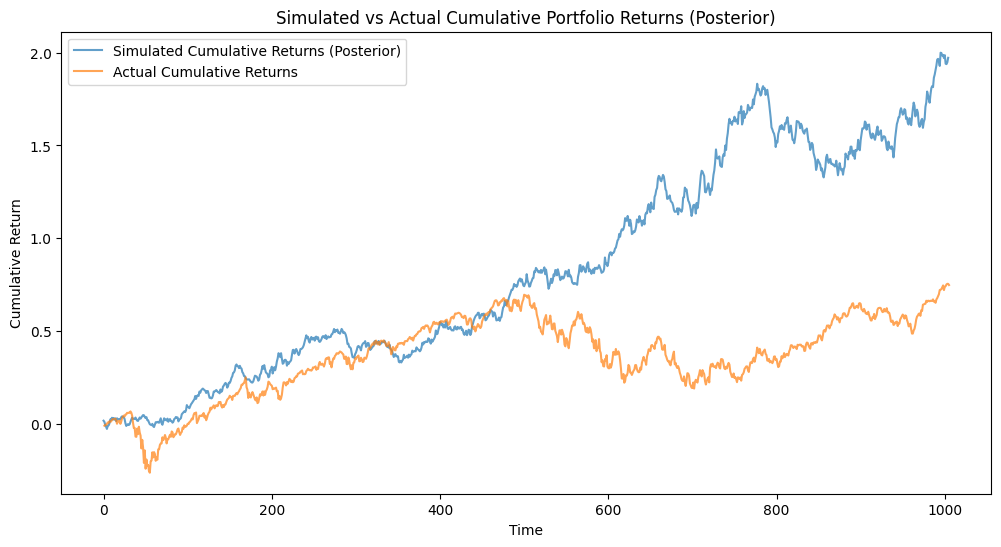

In [186]:
simulated_cumulative_returns_posterior = np.cumprod(1 + simulated_portfolio_returns_posterior) - 1
actual_cumulative_returns = np.cumprod(1 + actual_portfolio_returns) - 1

plt.figure(figsize=(12, 6))
plt.plot(simulated_cumulative_returns_posterior[:1005], label='Simulated Cumulative Returns (Posterior)', alpha=0.7)
plt.plot(actual_cumulative_returns, label='Actual Cumulative Returns', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Simulated vs Actual Cumulative Portfolio Returns (Posterior)')
plt.legend()
plt.show()

# This isn't bad at all, simulated follows actual before diverging, but this behavior is absolutely possible in a stock market context. Back testing being off doesn't necessarily mean the model is bad.